<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "DG,CA"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/DG,CA/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


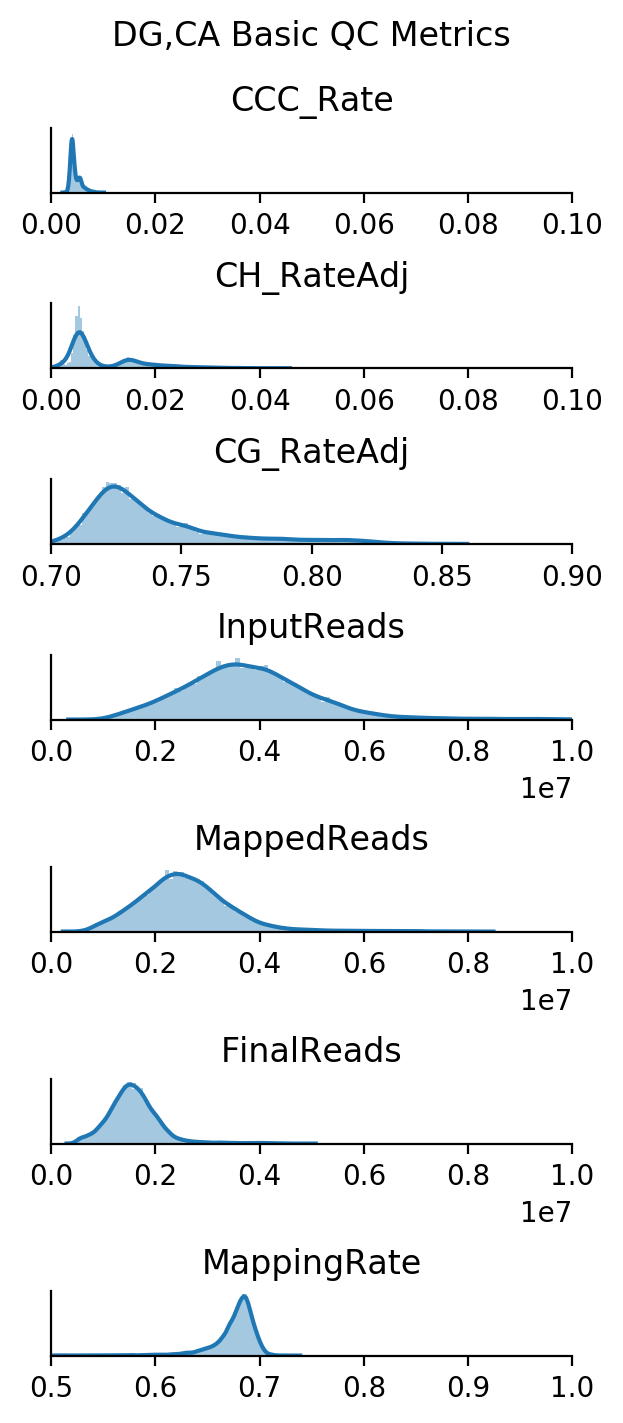

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

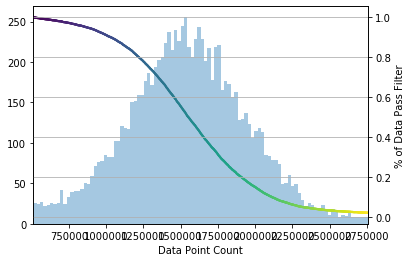

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 10240/10240 (100.0%)
CG_RateAdj passed 10240/10240 (100.0%)
CH_RateAdj passed 10240/10240 (100.0%)
FinalReads passed 10240/10240 (100.0%)
MappingRate passed 10240/10240 (100.0%)
Overall passed 10240/10240 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190212 1348
190214 2478
190219 1168
190305 2413
190625 411
190627 132
190711 1337
190716 953


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1190 309.9%
ad002 1292 336.5%
ad004 1270 330.7%
ad006 1256 327.1%
ad007 1304 339.6%
ad008 1288 335.4%
ad010 1310 341.1%
ad012 1330 346.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
10F_M_0,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.005266,0.737680,0.736291,0.021377,0.016197,1246547.0,3107022,2066022.0,10F,...,-11.400396,-2.194567,10.982877,24.083263,CA3 Cadm2,-0.815326,-3.349142,-8.356848,11.678943,True
10F_M_1,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.005682,0.742224,0.740751,0.022683,0.017098,1485896.0,3734938,2525631.0,10F,...,-9.436001,-2.229022,13.405496,16.300634,CA3 Cadm2,1.141752,-1.899265,-2.015848,13.891705,True
10F_M_100,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003786,0.727357,0.726321,0.008187,0.004417,1676504.0,4403880,2907194.0,10F,...,-18.139166,-7.085547,17.374093,1.317368,DG dg-all,-2.913669,-10.620528,35.510980,10.160927,True
10F_M_101,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003874,0.732602,0.731562,0.009119,0.005265,1521056.0,3916772,2680766.0,10F,...,-16.798029,-10.583722,-1.167818,13.570088,DG dg-all,-0.040006,-5.979399,-1.705960,-5.746715,True
10F_M_102,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003926,0.744868,0.743862,0.008893,0.004987,1252739.0,3416724,2206900.0,10F,...,-16.503090,-7.820477,19.073514,14.574505,DG dg-all,0.335689,-9.526454,21.984578,-3.167487,True
10F_M_1087,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003675,0.724650,0.723634,0.008977,0.005322,1524574.0,3795394,2542904.0,10F,...,-17.862486,-11.804235,-8.214344,3.454927,DG dg-all,-1.935111,-3.892900,-11.519581,8.509153,True
10F_M_1088,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003730,0.725905,0.724879,0.009425,0.005715,1812874.0,4578440,3088472.0,10F,...,-16.645477,-11.694553,-5.785034,9.076641,DG dg-all,-0.122210,-4.791686,-8.158715,1.504747,True
10F_M_1089,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003672,0.737614,0.736647,0.009130,0.005479,1876674.0,4703172,3177325.0,10F,...,-17.123089,-12.105506,-8.852769,5.151476,DG dg-all,-0.673461,-3.677578,-14.181396,3.084222,True
10F_M_1092,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.003755,0.726197,0.725165,0.008047,0.004309,1313788.0,3409434,2227830.0,10F,...,-17.474539,-6.325509,19.766943,4.322019,DG dg-all,-0.728106,-12.676880,37.484407,-8.450756,True
10F_M_1093,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.004049,0.735435,0.734360,0.010759,0.006738,1496935.0,3796072,2573795.0,10F,...,-15.929861,-14.832578,-19.612543,17.997404,DG dg-all,1.979184,-0.244563,-31.254156,-9.869756,True
